## import modules

In [ ]:
# import mudules
# python standard
import os
import sys
import scipy
import glob
import numpy as np
from scipy import odr
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

# SO specific
from sotodlib import core
from sotodlib.core import Context
from sotodlib.tod_ops import apodize, detrend
import sotodlib.io.load_smurf as ls
from sotodlib.io.load_smurf import Observations
#
from sotodlib.io import hk_utils
#
import sotodlib.hwp.hwp as hwp
from sotodlib.hwp.g3thwp import G3tHWP
#
from funcs_forTutorial import *


## set metadata

In [ ]:
# target
obs_id = 'obs_1705878834_satp1_1111111'
stream_id = 'ufm_mv19'

# stored directory
odir = '/so/home/hnakata/scratch/Analysis/SATMF1/midproducts/wg_step/'
dir_wg_op = odir+'lv3hk_plots/'

# metadata
# context file
context_root = '/so/home/hnakata/scratch/metadata/context/'
# context with det_match
context_fp = context_root + '2401_detmatch.yaml'
# HWP config file
hwp_config = context_root + '2401_hwp_satp1.yml'
# wire grid config file
wg_config = context_root + '2401_wg_satp1.yaml'


In [ ]:
# correspondence of stream_ids mv19(ws0), mv18(ws1), mv22(ws2), mv29(ws3), mv7(ws4), mv9(ws5), mv15(ws6)
MF1_stream_ids = ['ufm_mv19', 'ufm_mv18', 'ufm_mv22', 'ufm_mv29', 'ufm_mv7', 'ufm_mv9', 'ufm_mv15']

pA_per_phi0 = 9e6
phase_to_pA = pA_per_phi0 / (2*np.pi)
wg_degpercount = 360/52000
## end of the definition of the meta data ##

In [ ]:
hardware_offset = + 87
enc_offset = + 47.37 + 33.5
wg_offset = hardware_offset + enc_offset

# Demo with the sigle line

In [ ]:
ctx = Context(context_fp)
am = get_aman(ctx, obs_id, stream_id)
# here temoporarily restrict your AxisManager with the first 10 dets for the demonstration
am = am.restrict('dets', am.dets.vals[:10])

In [ ]:
# wrap the house-keeping data of HWP
am = wrap_hwp_angle(am, wg_config, hwp_config)
#
# analyze TOD and demodulate the signals
detrend.detrend_tod(am, method='median')
apodize.apodize_cosine(am)
am.hwp_angle = 2*np.pi - am.hwp_angle # only for MF1, 24.01
hwp.demod_tod(am, signal_name='signal')

### Here is the demo line

In [ ]:
# Here is the demo line
am = get_det_angle(am, wg_config=wg_config, wg_offset=wg_offset, stopped_time=10)

(array([2., 4., 0., 0., 1., 0., 2., 0., 0., 1.]),
 array([  9.96739669,  26.13477481,  42.30215294,  58.46953106,
         74.63690918,  90.80428731, 106.97166543, 123.13904356,
        139.30642168, 155.47379981, 171.64117793]),
 <BarContainer object of 10 artists>)

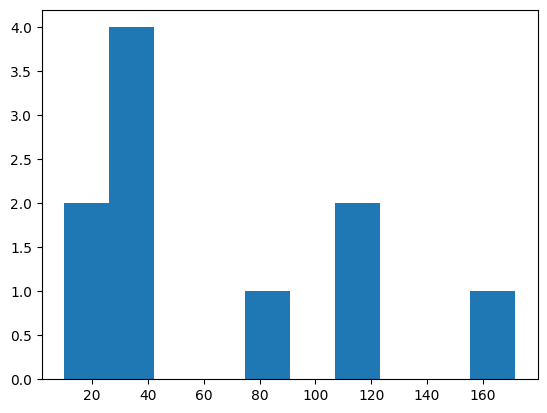

In [ ]:
plt.hist(am.wg.det_angle_raw)

# Tutorial in detail

## Get AxisManger and wrap the house-keeping data

In [ ]:
ctx = Context(context_fp)
am0 = get_aman(ctx, obs_id, stream_id)

In [ ]:
# here temoporarily restrict your AxisManager with the first 10 dets for the demonstration
am0 = am0.restrict('dets', am0.dets.vals[:10])

In [ ]:
# wrap the house-keeping data of HWP
am0 = wrap_hwp_angle(am0, wg_config, hwp_config)

In [ ]:
# wrap the house-keeping data of the wire grid
am0 = wg_wrap_hk(am0, wg_config)

## check the operation of the wire grid

In [ ]:
def _get_operation_range(aman):
    idx_wg_inside = np.where(aman.wg.LSR2.astype(int) | aman.wg.LSL2.astype(int))[0]
    return idx_wg_inside

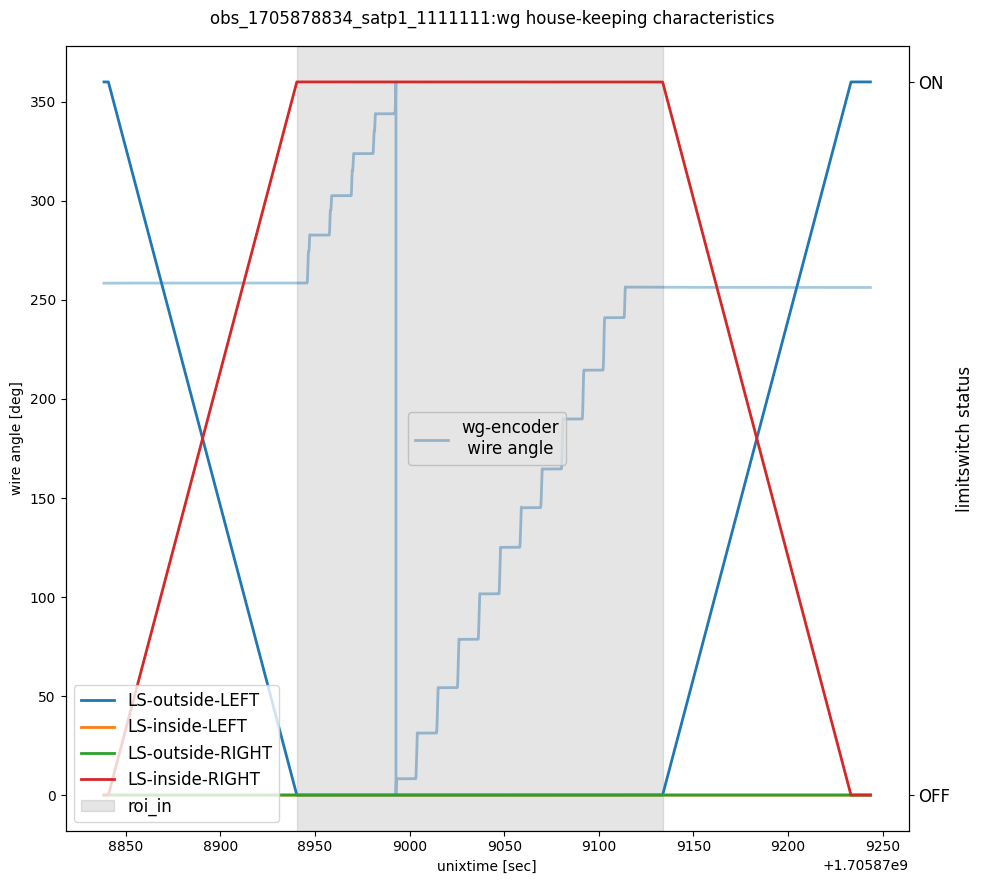

In [ ]:
# define the region of the wire grid operation
idx_wg_inside = _get_operation_range(am0)
# and plot the data with the shade of the range above
plot_wg_op(obs_id, am0, idx_wg_inside)

## Perform demodulation by HWP and calibrate TODs

In [ ]:
# analyze TOD and demodulate the signals
detrend.detrend_tod(am0, method='median')
apodize.apodize_cosine(am0)
am0.hwp_angle = 2*np.pi - am0.hwp_angle # only for MF1, 24.01
hwp.demod_tod(am0, signal_name='signal')

In [ ]:
am0 = am0.restrict('samps', (idx_wg_inside[0], idx_wg_inside[-1]))

In [ ]:
am0 = wg_wrap_QU(am0, 10) # 10 is the stopped time of the nominal operation

In [ ]:
am0 = wg_get_cfitres(am0)

In [ ]:
am0 = wg_get_lfitres(am0)

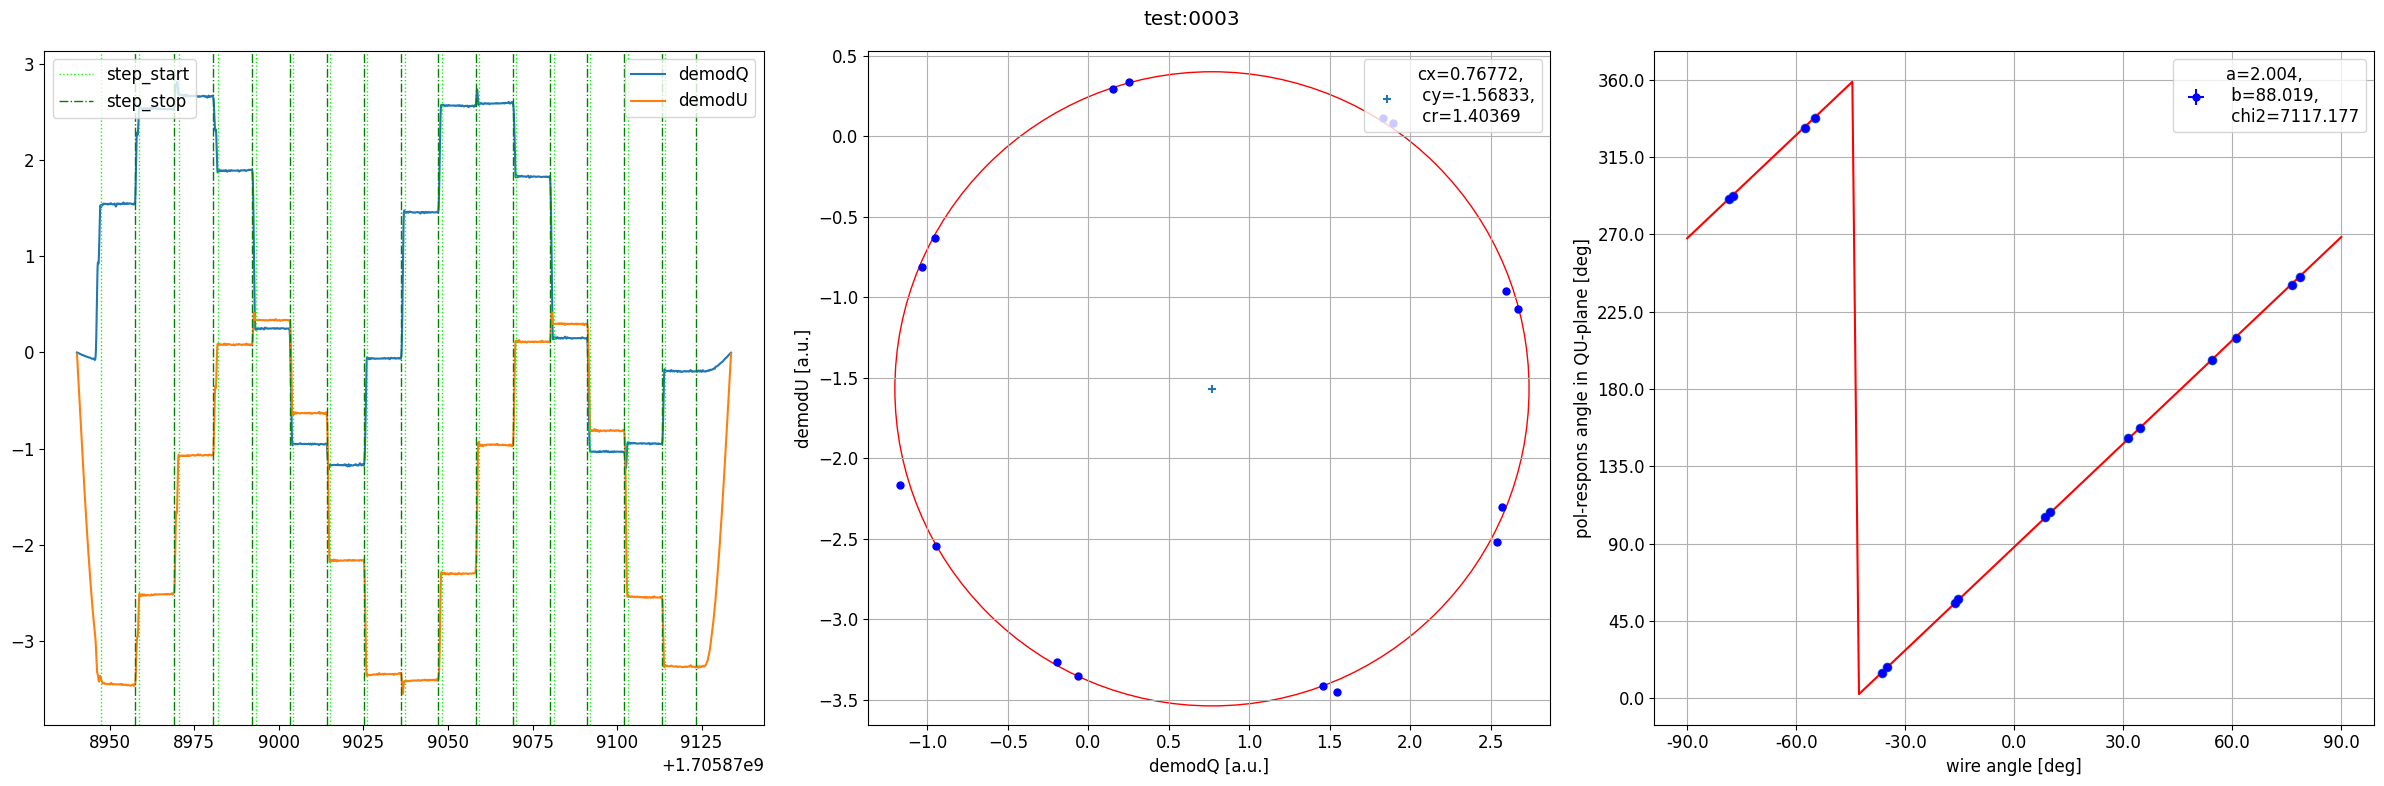

In [ ]:
detid = 3
plot_wg_charac(am0, detid)

In [ ]:
det_angle_raw = 0.5*(am0.wg.lfitval[:,1] + am0.wg.lfitval[:,0]*(wg_offset))%180
det_angle_raw_err = 0.5*am0.wg.lfiterr[:,1] # temporal value

(array([2., 4., 0., 0., 1., 0., 2., 0., 0., 1.]),
 array([  9.98607352,  26.16443277,  42.34279202,  58.52115127,
         74.69951052,  90.87786977, 107.05622902, 123.23458828,
        139.41294753, 155.59130678, 171.76966603]),
 <BarContainer object of 10 artists>)

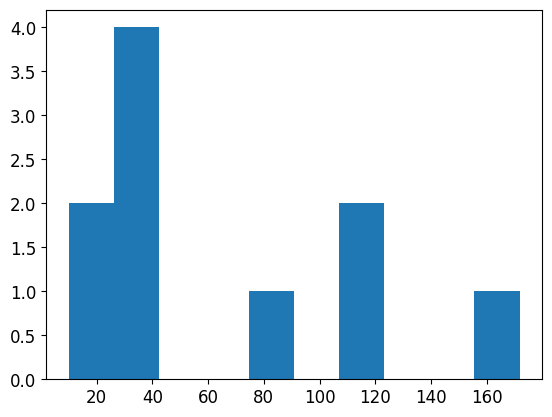

In [ ]:
plt.hist(det_angle_raw)